# Libraries 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
from scipy.special import i0
from numpy import exp, sin, cos
import seaborn as sns
import matplotlib as mpl
import os
from pathlib import Path
from statsFuncs import mean_confidence_interval as ms
from statsFuncs import compDistributions
import scipy
import random

mpl.rcParams['axes.linewidth'] = 2

# Paths 

In [2]:
fig3_path = os.getcwd()
figures_path = str(Path(fig3_path).parent)
datapath = figures_path + '/data/radiologists/Analysis5_22_2020/'

# Plot params

In [3]:
mpl.rcParams['xtick.major.size'] = 6
mpl.rcParams['xtick.major.width'] = 2
mpl.rcParams['ytick.major.size'] = 6
mpl.rcParams['ytick.major.width'] = 2
mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['ytick.direction'] = 'in'
mpl.rcParams['font.serif'] = 'Myriad Pro'
mpl.rcParams['font.weight'] = 'medium'
mpl.rcParams['font.size'] = 16
mpl.rcParams['axes.labelweight'] = 'medium'

# Subject params 

In [4]:
files = folders = 0

for _, dirnames, filenames in os.walk(datapath):
  # ^ this idiom means "we won't be using this value"
    files += len(filenames)
    folders += len(dirnames)

print("{:,} files, {:,} folders".format(files, folders))
print(str(folders-1) + ' subjects')
nSubjects = folders-1

95 files, 15 folders
14 subjects


In [5]:
subject_names = ['S1', 'S3', 'S4', 'S6', 'S7', 'S8', 's9', 's10', 's11', 's12', 's13', 's14', 's15']

# Load data 

In [6]:
alldata = pd.DataFrame(columns=['SUBJECT', 'trialNumber', 'shifted_stimulusID', 'shifted_morphID', 'Error', 'responseError'])
# alldata_trimed = pd.DataFrame(columns=['SUBJECT', 'AVG_RESPONSE_ERROR'])

row = 0
for subject in subject_names:
    subjectdata_temp = pd.DataFrame()
    print(subject)
    
    # load data:
    subjectdata = pd.read_csv(datapath + subject + '/' + subject + '_VM_output_1nBack.csv')
    subjectdata_temp = subjectdata[['trialNumber', 'shifted_stimulusID', 'shifted_morphID', 'Error', 'responseError']]
    subjectdata_temp = subjectdata_temp[(subjectdata_temp['trialNumber'] >= 1) & (subjectdata_temp['trialNumber'] <= 184)]
    print(len(subjectdata_temp))
    subjectdata_temp.loc[:, 'SUBJECT'] = subject
    

    if subject == 'S1':
        alldata = subjectdata_temp
    else:
        alldata = pd.concat([alldata, subjectdata_temp])
    
    row += 1
    
alldata['responseError'] = abs(alldata['responseError'])
alldata['Error'] = abs(alldata['Error'])



S1
250
S3
243
S4
247
S6
249
S7
248
S8
246
s9
248
s10
249
s11
246
s12
247
s13
247
s14
251
s15
245


# Polar plot

## Means per location 

In [7]:
# we have 147 locations
by_loc_by_subject = alldata.groupby(by=['SUBJECT', 'shifted_morphID'], as_index=False).mean()
by_loc_by_subject

,SUBJECT,shifted_morphID,trialNumber,shifted_stimulusID,Error,responseError
0,S1,1.0,58.333333,146.333333,0.666667,5.348264
1,S1,2.0,56.000000,126.000000,22.000000,33.897536
2,S1,3.0,21.000000,143.000000,6.000000,7.502917
3,S1,4.0,36.500000,9.000000,5.000000,9.958084
4,S1,7.0,56.000000,136.000000,17.000000,17.007263
...,...,...,...,...,...,...
1467,s9,143.0,72.000000,147.000000,4.000000,2.477495
1468,s9,144.0,60.500000,73.500000,2.500000,1.967905
1469,s9,145.0,34.000000,10.000000,11.000000,10.178379
1470,s9,146.0,12.500000,139.000000,7.000000,3.243152


## Corrected Error 

In [8]:
# alldata.dropna(inplace=True)
shifted_morph_df = pd.DataFrame(columns=['shifted_morphID', 'responseError', 'responseError_SEM'])

row=0

for morph in alldata.shifted_morphID.unique():
    
    tmp = alldata[alldata['shifted_morphID'] == morph]
    
    mean_morph, sem_morph = ms.mean_sem_returnsem(tmp['responseError'])
    
    shifted_morph_df.loc[row, 'shifted_morphID'] = morph
    shifted_morph_df.loc[row, 'responseError'] = mean_morph
    shifted_morph_df.loc[row, 'responseError_SEM'] = sem_morph
    
    row += 1
    
shifted_morph_df.sort_values(by=['shifted_morphID'], inplace=True)
shifted_morph_df.reset_index(drop=True, inplace=True)

In [46]:
theta = []
for deg in shifted_morph_df.shifted_morphID.unique():
    theta.append(np.pi / 73.5 * deg)
label_morphs = [str(i) for i in shifted_morph_df['shifted_morphID'].astype('int')]

# x = np.arange(0, len(theta), step =10)
x = np.arange(4, len(theta), step=5)
x = np.insert(x, 0, 0)
new_ticks = list()
new_label_morphs = list()

for i in x:
    new_ticks.append(theta[i])
    new_label_morphs.append(label_morphs[i])


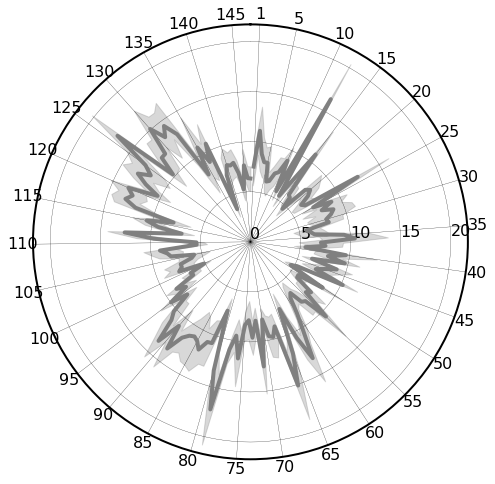

In [67]:

    # create figure
plt.figure(figsize=(8, 8))
ax = plt.axes(polar=True)
df= shifted_morph_df[['responseError']]
df_error = shifted_morph_df[['responseError_SEM']]
df_reset_index = df.reset_index(drop=True)
df.index = [theta[location] for location in df.index]
df.plot(ax=ax, lw=4, color=['gray'])

ax.fill_between(np.asarray(theta), np.asarray(df_reset_index['responseError'] - df_error['responseError_SEM'], dtype='float'), 
                np.asarray(df_reset_index['responseError'] + df_error['responseError_SEM'], dtype='float'), color='gray', alpha=0.3)
ax.set_theta_zero_location("N")
ax.set_xticks(new_ticks)
ax.set_xticklabels(labels=new_label_morphs)

# plt.thetagrids(np.arange(0, 360, 60), labels=new_label_morphs)
plt.grid(color='black', linewidth=0.25)
ax.set_facecolor('white')
ax.set_theta_direction(-1)
ax.get_legend().remove()
ax.set_rlabel_position(89)
ax.set_yticks(np.arange(0, 25, step=5))


plt.show()

## Non-corrected error 

In [70]:
# alldata.dropna(inplace=True)
shifted_morph_df = pd.DataFrame(columns=['shifted_morphID', 'Error', 'Error_SEM'])

row=0

for morph in alldata.shifted_morphID.unique():
    
    tmp = alldata[alldata['shifted_morphID'] == morph]
    
    mean_morph, sem_morph = ms.mean_sem_returnsem(tmp['Error'])
    
    shifted_morph_df.loc[row, 'shifted_morphID'] = morph
    shifted_morph_df.loc[row, 'Error'] = mean_morph
    shifted_morph_df.loc[row, 'Error_SEM'] = sem_morph
    
    row += 1
    
shifted_morph_df.sort_values(by=['shifted_morphID'], inplace=True)
shifted_morph_df.reset_index(drop=True, inplace=True)

In [71]:
theta = []
for deg in shifted_morph_df.shifted_morphID.unique():
    theta.append(np.pi / 73.5 * deg)
label_morphs = [str(i) for i in shifted_morph_df['shifted_morphID'].astype('int')]

# x = np.arange(0, len(theta), step =10)
x = np.arange(4, len(theta), step=5)
x = np.insert(x, 0, 0)
new_ticks = list()
new_label_morphs = list()

for i in x:
    new_ticks.append(theta[i])
    new_label_morphs.append(label_morphs[i])


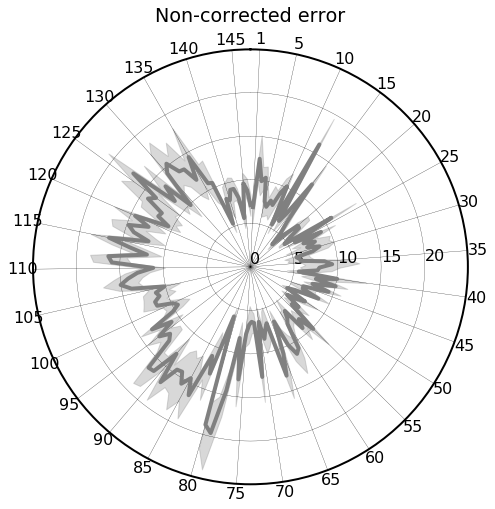

In [73]:

    # create figure
plt.figure(figsize=(8, 8))
ax = plt.axes(polar=True)
df= shifted_morph_df[['Error']]
df_error = shifted_morph_df[['Error_SEM']]
df_reset_index = df.reset_index(drop=True)
df.index = [theta[location] for location in df.index]
df.plot(ax=ax, lw=4, color=['gray'])

ax.fill_between(np.asarray(theta), np.asarray(df_reset_index['Error'] - df_error['Error_SEM'], dtype='float'), 
                np.asarray(df_reset_index['Error'] + df_error['Error_SEM'], dtype='float'), color='gray', alpha=0.3)
ax.set_theta_zero_location("N")
ax.set_xticks(new_ticks)
ax.set_xticklabels(labels=new_label_morphs)

# plt.thetagrids(np.arange(0, 360, 60), labels=new_label_morphs)
plt.grid(color='black', linewidth=0.25)
ax.set_facecolor('white')
ax.set_theta_direction(-1)
ax.get_legend().remove()
ax.set_rlabel_position(89)
ax.set_yticks(np.arange(0, 25, step=5))
plt.title('Non-corrected error')

plt.show()

In [74]:
shifted_morph_df

,shifted_morphID,Error,Error_SEM
0,1,6.85714,1.83493
1,2,12.4483,2.66365
2,3,9.91429,1.63593
3,4,10.3793,1.30215
4,5,7.68421,1.76723
...,...,...,...
142,143,8.05714,1.06664
143,144,5.64,1.15885
144,145,9.625,1.1869
145,146,8.80645,1.35394


In [78]:
col = by_loc_by_subject.loc[: , "Error":"responseError"]
by_loc_by_subject['mean_errors'] = col.mean(axis=1)

In [81]:
sum(by_loc_by_subject['Error'] < by_loc_by_subject['responseError'])/len(by_loc_by_subject)

0.45652173913043476